In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'})
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={"vopenid":"object"})

In [3]:
df_merged = pd.merge(df_login, df_purchase, on='vopenid', how='inner')
df_merged.shape

(36125, 35)

In [4]:
feature_cols = [
    'total_purchase','num_purchase','max_purchase','avg_purchase','frequency_purchase',
    'count_purchase_on_day','std_amount_purchase','days_since_last_purchase','num_product_buyed',
    'num_login','num_day_login','login_frequency','avg_weekly_login','std_weekly_login',
    'streak_login','days_since_last_login','popular_time_login','gold_std_login','diamond_std_login',
    'silkcoin_std_login','gold_slope_login','diamond_slope_login','silkcoin_slope_login',
    'short_lifetime_flag','powerpoint_last_login','level_last_login','vip_last_login'
]

df_merged["event"] = df_merged["event"].astype(bool)   

In [5]:
X = df_merged[feature_cols]
y = Surv.from_arrays(event=df_merged["event"], time=df_merged["duration"])
vopenids = df_merged["vopenid"].values

X_train, X_test, y_train, y_test, vopenids_train, vopenids_test = train_test_split(
    X, y, vopenids, test_size=0.2, random_state=42, stratify=df_merged["event"]
)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
rsf = RandomSurvivalForest(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    max_depth=20,
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train_scaled, y_train)

RandomSurvivalForest(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                     n_estimators=500, n_jobs=-1, random_state=42)

In [13]:
risk_scores = rsf.predict(X_test_scaled)
c_index = concordance_index_censored(
    y_test["event"],   
    y_test["time"],    
    risk_scores         
)[0]
print(f"C-index: {c_index:.4f}")

C-index: 0.9261


In [19]:
def predict_survival_for_user(vopenid=None, test_index=None):
    if vopenid is not None:
        idx = np.where(vopenids_test == vopenid)[0]
        if len(idx) == 0:
            print("Not found user")
            return
        user_index = idx[0]
    elif test_index is not None:
        if test_index < 0 or test_index >= len(X_test_scaled):
            print("Invalid test_index")
            return
        user_index = test_index
    else:
        print("Input must be vopenid or test_index!")
        return

    x_one = X_test_scaled[user_index].reshape(1, -1)
    risk = rsf.predict(x_one)[0]
    sf_func = rsf.predict_survival_function(x_one)
    sf = sf_func[0].y
    timeline = sf_func[0].x

    if np.any(sf <= 0.5):
        median_surv_time = timeline[np.where(sf <= 0.5)[0][0]]
    else:
        median_surv_time = timeline[-1]

    def get_survival_prob_at(days, timeline, sf):
        if days in timeline:
            idx = np.where(timeline == days)[0][0]
            return sf[idx]
        else:
            idx = np.searchsorted(timeline, days, side='right') - 1
            return sf[idx] if idx >= 0 else 1.0

    s7 = get_survival_prob_at(7, timeline, sf)
    s30 = get_survival_prob_at(30, timeline, sf)

    print(f"User vopenid={vopenids_test[user_index]} | test_index={user_index} Metrics:")
    print(f"- Risk score: {risk:.4f}")
    print(f"- Median survival time: {median_surv_time:.2f} days")
    print(f"- Survive 7d: {s7:.3f}, Survive 30d: {s30:.3f}")
    print(f"- Timeline (day: P[still active]):")
    # for t, p in zip(timeline, sf):
    #     print(f"  Day {t:.0f}: P = {p:.3f}")
    return risk,median_surv_time,s7,s30

#predict_survival_for_user(vopenid=2503131708350272)
risk,median_surv_time,s7,s30=predict_survival_for_user(test_index=500)

User vopenid=2406160410022518 | test_index=500 Metrics:
- Risk score: 16.9929
- Median survival time: 43.00 days
- Survive 7d: 0.999, Survive 30d: 0.763
- Timeline (day: P[still active]):


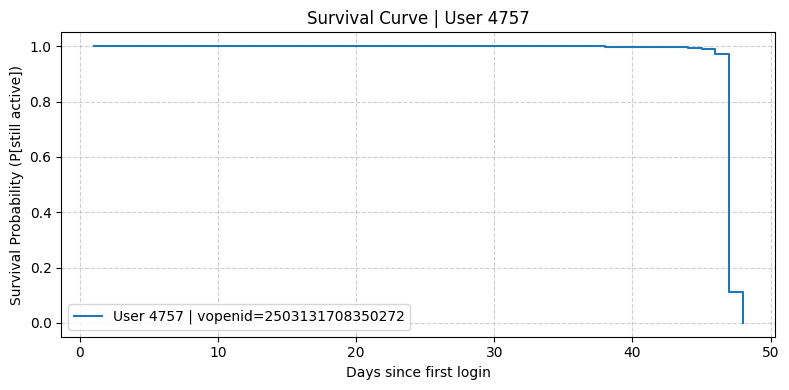

In [ ]:
def plot_survival_curve_for_user(X_test_scaled, vopenids_test, rsf, test_index=None, vopenid=None
):

    if vopenid is not None:
        idx = np.where(vopenids_test == vopenid)[0]
        if len(idx) == 0:
            print("Not found user")
            return
        user_index = idx[0]
    elif test_index is not None:
        if test_index < 0 or test_index >= len(X_test_scaled):
            print("Invalid test_index")
            return
        user_index = test_index
    else:
        print("Input must be vopenid or test_index!")
        return

    x_one = X_test_scaled[user_index].reshape(1, -1)
    sf_func = rsf.predict_survival_function(x_one)
    sf = sf_func[0].y
    timeline = sf_func[0].x
    user_vopenid = vopenids_test[user_index]

    plt.figure(figsize=(8, 4))
    plt.step(timeline, sf, where='post', label=f'User {user_index} | vopenid={user_vopenid}')
    plt.title(f"Survival Curve | User {user_index}")
    plt.xlabel('Days since first login')
    plt.ylabel('Survival Probability (P[still active])')
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# plot_survival_curve_for_user(X_test_scaled=X_test_scaled,vopenids_test=vopenids_test,rsf=rsf,test_index=400)
plot_survival_curve_for_user(X_test_scaled=X_test_scaled,vopenids_test=vopenids_test, rsf=rsf,vopenid="2503131708350272")

In [20]:
churn_proba = 0.502    
alpha = 0.5            
risk_score = alpha * churn_proba + (1 - alpha) * (1 - s30)
print(f"Risk score combined: {risk_score:.4f}")

Risk score combined: 0.3696
